# IBM Data Science Professional Certificate
# Capstone project

This notebook is created for the capstone project in the course 'Applied Data Science Capstone'. The purpose of the program discribed by this notebook is to use the Foursquare API to explore the neighbourhoods in Singapore and Paris to determine if there are similarities in venues for the  neighborhoods.

# Executive Summary

The Capstone Project for the IBM Data Science Professional Certificate is to create a program to leveraging the FourSquare location data to explore or compare neighborhoods or cities of my choice. The program created attempts to solve the problem faced by travelers or migrants when they decide on a neighborhood to stay while traveling to another city. The program compares the neighborhoods of Singapore (Planning Areas) and Paris (Quartiers). The analysis uses K Means to cluster the neighborhoods in each city, to find which neighborhoods have the same amenities. The analysis has found 3 Parisian neighborhoods, in 2 of the clusters, have similar amenities to neighborhoods in Singapore. These neighborhoods are proposed as places that migrants should consider staying. For travelers, 2 other clusters are proposed to address the issue this program is designed to address.

# Table of Contents

* Introduction: Business Problem
* Data Description
* Methodology
* Analysis
* Results and Discussion
* Conclusion

# Introduction: Business Problem

France, and her capital Paris, is one of the premier travel destinations in the world. This can also be said of an international city like Singapore. With Singapore and Paris being two cities that are major centers of finance, commerce and arts in their respective regions, a comparison of the venues in each neighborhood at both cities can provide unique insights. As a resident of Singapore and having a desire to travel to Europe and see the ‘City of Lights’, a comparison of both cities would give nice overview of the neighborhoods in the city.

Recently, travelers desire a more authentic view of countries, as can be seen by the rise of AirBnB. This program aims to provide travelers with data to make a choice on which neighborhood they can consider staying in. Therefore, the target audience would be travelers and migrants moving from Singapore to Paris. For example, a traveler travelling to Paris from Singapore might want to know if a neighborhood is able to provide a more authentic travel experience with immersion to French culture yet provide similar amenities as their neighborhoods back in Singapore. Another example would be to advise an immigrant from Singapore to Paris if a neighborhood provides similar amenities like another neighborhood in Singapore.

This program would provide a quick macro view of the neighborhoods in Singapore and Paris and cluster the neighborhoods by the venues or amenities provided. Specifically, the program leverages on the Foursquare API and K Means Clustering to help travelers or immigrants decide on neighborhoods to stay in Paris that are like neighborhoods in Singapore by comparing venues in the neighborhoods. The clusters generated using the neighborhood data for both Singapore and Paris will help provide guidance to the stakeholders of this project for their final decision.


### Loading necessary libraries

The following cells imports the necessary libraries. The cells are split according to the intent and use of the libraries. The second cell installs geopy, geocoder, bs4 and lxml, if necessary. The second cell imports the necessary libraries for data scraping and pre-processing.  The last cell imports the libraries necessary for data visualisation and clustering.

In [1]:
# The following line of code is for the installation of the necessary libraries.
# Code is commented as libraries have been installed

#!pip install geopy
#!pip install geocoder
#!pip install bs4
#!pip install lxml
#!pip install folium

print("Installation Complete")

Installation Complete


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import requests
from bs4 import BeautifulSoup
import urllib.request

print('Libraries imported')

Libraries imported


In [3]:
import json
import geocoder
from  geopy.geocoders import Nominatim
from pandas import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

print('Libraries imported')

Libraries imported


# Data Description

### Data Sources

The data used in this program was obtained from the World Bank website as a CSV file, from the Wikipedia website using ‘BeautifulSoup’ and location data is obtained using the ‘FourSquare’ API.

### Data Cleaning (Europe Travel Data)

To build the business case for selecting France, and by extension its capital Paris, we look at the data provided by the World Bank. The data is contained in 2 files that are downloaded from the website. This data is provided in CSV format and shows the international arrivals to France from 1995 to 2018, and the country information. The first file consists of the country names and its regional and income information. The second file consists of the travel data from 1960 to 2019.

The data contained in the files consists of country, regional and continental data. As the regional and continental data is not required, these data are removed from the files. To make the dataset more manageable, we choose only countries that are in the ‘Europe & Central Asia’ region, as well as those that are in the High-Income group. The files are then merged. Null values are replaced with a ‘0’ value in this dataset. This is to prevent the data being skewed unnecessarily. 

We note that data relating to international arrivals from 1960 to 1995 and data pertaining to 2019 are not included into the dataset. Therefore, these years with no data are not considered for our analysis and are dropped from the dataset. There are 38 countries in the dataframe we created. To make the dataset more manageable and to make data visualization clearer, we will take the top 10 countries with the highest total international arrivals.

### Data Cleaning (Neighborhood Data)

The neighborhood data is obtained from Wikipedia pages detailing the planning areas of Singapore and the breakdown of the Paris ‘Arrondissement’ system. The ‘BeautifulSoup’ package is used to parse the required data from the separate webpages into Python. The 2 Wikipedia pages contain a table detailing the respective neighborhoods. For the Wikipedia page containing the Singapore neighborhood data, the table consists of 9 columns. We pull the data from the ‘Name’, ‘Region’, ‘Area’ and ‘Population’ columns. As the data obtained under the ‘Name’ column is for the ‘Planning Areas’ in Singapore, we will be using it as the list of Neighborhoods. For the Wikipedia page containing the Paris neighborhood data, the table consists of 5 columns.

The parsed data is then pre-processed to a Data Frame of 4 columns. The 4 columns are ‘Neighborhood’, ‘Region’, ‘Area’ and the ‘Population’. The ‘Neighborhood’ column details the name of the neighborhood or planning area reviewed. The ‘Region’ details the planning region used by the city. The ’Area’ column details the size of the Neighborhood reviewed and are measured in kilometers squared, km2. The ‘Population’ column details the population living in the area per the last census conducted.

The Data obtained for Singapore contains areas where there are no residential areas, these are seen by the null value in the population column. These values are dropped from the dataset as they provide no meaningful information. Additionally, as Singapore is a dense urban environment, areas that are below 2000 in population are removed from the data as these areas are either areas with large water catchment zones or industrial areas.

 The Data obtained for the Paris neighborhoods do not contain any NaN data. The ‘Arrondissement’ data is equated to the ‘Region’ data for Singapore. While the Quarter or ‘Quartiers’ data is equated to the ‘Neighborhood’ data. The population data is processed to make it an integer and the Area data is processed into float data type.
 
Based on the problem definition, we choose 2 specific criteria that would influence our decision. The first is the similarity of venues at each neighborhood. The second the presence of neighborhoods from the base city of Singapore in each cluster.

## Data Preparation & Pre-Processing

### Data from 1st set of CSV files from WorldBank

In [4]:
country_url = 'https://raw.githubusercontent.com/zerongtan-kevin/Coursera_Capstone/master/Metadata_Country.csv'
country_data = pd.read_csv(country_url, error_bad_lines=False)
country_data.head()

,Country Code,Region,IncomeGroup,SpecialNotes,Country
0,ABW,Latin America & Caribbean,High income,NaN,Aruba
1,AFG,South Asia,Low income,NaN,Afghanistan
2,AGO,Sub-Saharan Africa,Lower middle income,NaN,Angola
3,ALB,Europe & Central Asia,Upper middle income,NaN,Albania
4,AND,Europe & Central Asia,High income,NaN,Andorra


We find obtain the dataframe information. This is to allow us to manage the dataframe and make it more manageable for later analysis.

In [5]:
country_data = pd.DataFrame(country_data)
print(country_data.columns)
country_data = country_data.drop(['SpecialNotes'], axis=1)
country_data = country_data.dropna()
print(country_data.shape)
country_data.info()

Index(['Country Code', 'Region', 'IncomeGroup', 'SpecialNotes', 'Country'], dtype='object')
(217, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 262
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Code  217 non-null    object
 1   Region        217 non-null    object
 2   IncomeGroup   217 non-null    object
 3   Country       217 non-null    object
dtypes: object(4)
memory usage: 8.5+ KB


In [6]:
country_data.set_index(['Country']).loc[['Singapore', 'France']]

,Country Code,Region,IncomeGroup
Country,,,
Singapore,SGP,East Asia & Pacific,High income
France,FRA,Europe & Central Asia,High income


The country data is filtered to show the data that corresponds to the region that France is in and the Income Group the country belongs to. We note that both France and Singapore are in the High Income Group. This is to compare the countries or cities that are similar to Singapore and to see what the overall trend is.

In [7]:
country_data = country_data[(country_data['Region']=='Europe & Central Asia') & (country_data['IncomeGroup']=='High income')]
country_data = country_data.rename(columns={"Country": "Country Name"})
country_data = country_data.reset_index(drop=True)
country_data.head()

,Country Code,Region,IncomeGroup,Country Name
0,AND,Europe & Central Asia,High income,Andorra
1,AUT,Europe & Central Asia,High income,Austria
2,BEL,Europe & Central Asia,High income,Belgium
3,CHE,Europe & Central Asia,High income,Switzerland
4,CHI,Europe & Central Asia,High income,Channel Islands


### Data from 2nd CSV file pulled from World Bank.

In [8]:
france_travel = 'https://raw.githubusercontent.com/zerongtan-kevin/Coursera_Capstone/master/travel_data_France.csv'
fr_travel_data = pd.read_csv(france_travel, error_bad_lines=False)
fr_travel_data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,824000.0,869000.0,904000.0,979000.0,1072000.0,1225000.0,1102000.0,1070500.0,1082000.0,NaN
1,Afghanistan,AFG,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,425000.0,481000.0,528000.0,650000.0,595000.0,592000.0,397000.0,261000.0,218000.0,NaN
3,Albania,ALB,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,2191000.0,2469000.0,3156000.0,2857000.0,3341000.0,3784000.0,4070000.0,4643000.0,5340000.0,NaN
4,Andorra,AND,"International tourism, number of arrivals",ST.INT.ARVL,NaN,NaN,NaN,NaN,NaN,NaN,...,1808000.0,2242000.0,2238000.0,2328000.0,2363000.0,2663000.0,2819000.0,3003000.0,3042000.0,NaN


We process the raw data to make it easier to obtain insights from it. To do so, we obtain the sum of international arrivals of each city. This is followed by removing the columns where the information is unavailable or not required.

In [9]:
fr_travel_data['Total'] = fr_travel_data.sum(axis=1)
fr_travel_data = fr_travel_data.drop(columns=['Indicator Name', 'Indicator Code', 'Country Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
                            '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
                            '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
                            '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994'])
fr_travel_data = fr_travel_data.reset_index(drop=True)
fr_travel_data.head()

,Country Name,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total
0,Aruba,619000.0,641000.0,650000.0,647000.0,683000.0,721000.0,691000.0,643000.0,642000.0,...,869000.0,904000.0,979000.0,1072000.0,1225000.0,1102000.0,1070500.0,1082000.0,NaN,19631500.0
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,Angola,9000.0,21000.0,45000.0,52000.0,45000.0,51000.0,67000.0,91000.0,107000.0,...,481000.0,528000.0,650000.0,595000.0,592000.0,397000.0,261000.0,218000.0,NaN,6015000.0
3,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2469000.0,3156000.0,2857000.0,3341000.0,3784000.0,4070000.0,4643000.0,5340000.0,NaN,35871000.0
4,Andorra,NaN,NaN,NaN,NaN,2347000.0,2949000.0,3516000.0,3387000.0,3138000.0,...,2242000.0,2238000.0,2328000.0,2363000.0,2663000.0,2819000.0,3003000.0,3042000.0,NaN,51357000.0


#### Merging the 2 Dataframes created from the World Bank CSV files.

In [10]:
travel_fr=[]
years = list(map(str, range(1995, 2020)))
travel_fr = pd.merge(country_data, fr_travel_data, how='inner', on='Country Name', sort=False)
travel_fr = travel_fr.drop(['Country Code', 'Region', 'IncomeGroup'], axis=1)
travel_fr = travel_fr.fillna(0)
travel_fr.columns = list(map(str, travel_fr.columns))
#travel_fr = travel_fr.astype(int)
travel_fr[years] = travel_fr[years].astype('int64')
travel_fr['Total'] = travel_fr.sum(axis=1).astype('int64')
#travel_df = travel_df.drop(columns=['2019'], axis=1)
print(travel_fr.info())
travel_fr

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  38 non-null     object
 1   1995          38 non-null     int64 
 2   1996          38 non-null     int64 
 3   1997          38 non-null     int64 
 4   1998          38 non-null     int64 
 5   1999          38 non-null     int64 
 6   2000          38 non-null     int64 
 7   2001          38 non-null     int64 
 8   2002          38 non-null     int64 
 9   2003          38 non-null     int64 
 10  2004          38 non-null     int64 
 11  2005          38 non-null     int64 
 12  2006          38 non-null     int64 
 13  2007          38 non-null     int64 
 14  2008          38 non-null     int64 
 15  2009          38 non-null     int64 
 16  2010          38 non-null     int64 
 17  2011          38 non-null     int64 
 18  2012          38 non-null     int64 
 19  2013      

,Country Name,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Total
0,Andorra,0,0,0,0,2347000,2949000,3516000,3387000,3138000,...,2242000,2238000,2328000,2363000,2663000,2819000,3003000,3042000,0,102714000
1,Austria,17173000,17090000,16647000,17352000,17467000,17982000,18180000,18611000,19078000,...,23012000,24151000,24813000,25291000,26728000,28121000,29460000,30816000,0,1035268000
2,Belgium,5560000,5829000,6037000,6179000,6369000,6457000,6452000,6720000,6690000,...,7494000,7560000,7684000,7887000,8355000,7481000,8385000,9119000,0,337842000
3,Switzerland,6946000,6730000,7039000,7185000,7154000,7821000,7455000,6868000,6530000,...,8534000,8566000,8967000,9158000,9305000,9205000,9889000,10362000,0,373568000
4,Channel Islands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Cyprus,2100000,1950000,2088000,2223000,2434000,2686000,2697000,2418000,2303000,...,2392000,2465000,2405000,2441000,2659000,3187000,3652000,3939000,0,120786000
6,Czech Republic,3381000,4558000,4976000,5482000,5610000,4773000,5405000,4743000,5076000,...,6715000,7647000,7852000,8096000,8707000,9321000,10160000,10611000,0,315280000
7,Germany,14847000,15205000,15837000,16511000,17116000,18983000,17861000,17969000,18399000,...,28374000,30411000,31545000,32999000,34970000,35555000,37452000,38881000,0,1177042000
8,Denmark,0,2125000,2158000,2073000,2023000,3535000,3684000,3436000,3474000,...,8471000,8443000,8557000,10267000,10424000,10781000,12426000,12749000,0,332700000
9,Spain,32971000,34027000,39553000,41892000,45440000,46403000,48565000,50331000,50854000,...,56177000,57464000,60675000,64939000,68175000,75315000,81869000,82773000,0,2648968000


The data frame created does not clearly show the data that is desired. We now input additional code to increase the clarity of the dataframe created. Additionally, only the countries with the top 10 international arrivals are selected.

In [11]:
#Sorting out the data provided
travel_df = travel_fr.sort_values(by='Total', ascending=False)
travel_df = travel_df.drop(['Total', '2019'], axis=1)
travel_df = travel_df.set_index('Country Name')

#Choosing the top 10 most popular destination
travel_df = travel_df.head(10)
travel_df

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country Name,,,,,,,,,,,,,,,,,,,,,
France,60033000,62406000,66591000,70109000,73147000,77190000,75202000,77012000,75048000,74433000,...,76764000,76647000,80499000,81980000,83634000,83701000,84452000,82682000,86758000,89322000
Spain,32971000,34027000,39553000,41892000,45440000,46403000,48565000,50331000,50854000,52430000,...,52178000,52677000,56177000,57464000,60675000,64939000,68175000,75315000,81869000,82773000
Italy,31052000,34080000,34692000,34933000,36516000,41181000,39563000,39799000,39604000,37071000,...,43239000,43626000,46119000,46360000,47704000,48576000,50732000,52372000,58253000,61567200
United Kingdom,21719000,22936000,23215000,23710000,23341000,23212000,20982000,22307000,22787000,25678000,...,28199000,28295000,29306000,29282000,31063000,32613000,34436000,35814000,37651000,36316000
Germany,14847000,15205000,15837000,16511000,17116000,18983000,17861000,17969000,18399000,20137000,...,24220000,26875000,28374000,30411000,31545000,32999000,34970000,35555000,37452000,38881000
Austria,17173000,17090000,16647000,17352000,17467000,17982000,18180000,18611000,19078000,19374000,...,21355000,22004000,23012000,24151000,24813000,25291000,26728000,28121000,29460000,30816000
Greece,10130000,9233000,10070000,10916000,12164000,13096000,14057000,14180000,13969000,13313000,...,14915000,15007000,16427000,15518000,17920000,22033000,23599000,24799000,27194000,30123000
Poland,19215000,19410000,19520000,18780000,17950000,17400000,15000000,13980000,13720000,14290000,...,11890000,12470000,13350000,14840000,15800000,16000000,16728000,17471000,18258000,19622000
Netherlands,6574000,6580000,7841000,9312000,9874000,10003000,9500000,9595000,9181000,9646000,...,9921000,10883000,11300000,11680000,12783000,13925000,15007000,15828000,17924000,18780000


## Data Scraping using BeautifulSoup

We use the BeautifulSoup library to pull the neighborhood data of Singapore and Paris, from Wikipedia.

### (1) Neighborhoods (Planning Area) in Singapore

In [12]:
url = "https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, 'lxml')
table = soup.find('table', class_='wikitable sortable')

In [13]:
# Creating Lists to store data parsed from wikipedia

name = []
region = []
area = []
population = []

# Parsing data to created lists

for row in table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells)==9:
        atag = cells[0].find('a')
        name.append(atag.attrs['title'])
        regtag = cells[5].find('a')
        region.append(regtag.attrs['title'])
        area.append(cells[6].find(text=True))
        population.append(cells[7].find(text=True))
        

In [14]:
# Formatting Dataframe structure

sg_df = pd.DataFrame(name, columns = ['Neighborhood'])
sg_df['Region'] = region
sg_df['Area'] = area
sg_df['Population'] = population

# Formatting Data

sg_df['Area'] = sg_df['Area'].str.replace(r'\n', '')
sg_df['Population'] = sg_df['Population'].str.replace(r'\n', '')

# Check Data parsed
print(sg_df.shape)
sg_df

(55, 4)


,Neighborhood,Region,Area,Population
0,Ang Mo Kio,"North-East Region, Singapore",13.94,"163,950"
1,Bedok,"East Region, Singapore",21.69,"279,380"
2,"Bishan, Singapore","Central Region, Singapore",7.62,"88,010"
3,Boon Lay Planning Area,"West Region, Singapore",8.23,30
4,Bukit Batok,"West Region, Singapore",11.13,"153,740"
5,Bukit Merah,"Central Region, Singapore",14.34,"151,980"
6,Bukit Panjang,"West Region, Singapore",8.99,"139,280"
7,Bukit Timah,"Central Region, Singapore",17.53,"77,430"
8,Central Water Catchment,"North Region, Singapore",37.15,*
9,Changi,"East Region, Singapore",40.61,"1,830"


In [15]:
# Pre-Processing of dataframe

sg_df['Population'] = sg_df['Population'].replace(r'*', '0')
sg_df['Population'] = sg_df['Population'].str.replace(r',', '')
sg_df['Region'] = sg_df['Region'].str.replace(r', Singapore', '')
sg_df['Neighborhood'] = sg_df['Neighborhood'].str.replace(r', Singapore', '')
sg_df['Neighborhood'] = sg_df['Neighborhood'].str.replace(r' Planning Area', '')
sg_df['Population'] = sg_df['Population'].astype(int)
sg_df['Area'] = sg_df['Area'].astype(float)
sg_df = sg_df[sg_df.Population >= 2000]
sg_df.reset_index(inplace=True, drop=True)

sg_df

,Neighborhood,Region,Area,Population
0,Ang Mo Kio,North-East Region,13.94,163950
1,Bedok,East Region,21.69,279380
2,Bishan,Central Region,7.62,88010
3,Bukit Batok,West Region,11.13,153740
4,Bukit Merah,Central Region,14.34,151980
5,Bukit Panjang,West Region,8.99,139280
6,Bukit Timah,Central Region,17.53,77430
7,Choa Chu Kang,West Region,6.11,190890
8,Clementi,West Region,9.49,92420
9,Downtown Core,Central Region,4.34,2720


The neighborhood Bukit Timah drops a pin in a forested area. To address this issue, the neighborhood is revised to 'Upper Bukit Timah', so as to collect data using FourSquare API in a populated area.

In [16]:
sg_df['Neighborhood'][6] = sg_df['Neighborhood'][6].replace('Bukit Timah', 'Upper Bukit Timah')
sg_df['Neighborhood'][6]

C:\Users\invic\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\invic\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


'Upper Bukit Timah'

In [17]:
planArea = sg_df['Neighborhood'].tolist()
print(len(planArea))
planArea[:5]

34


['Ang Mo Kio', 'Bedok', 'Bishan', 'Bukit Batok', 'Bukit Merah']

In [18]:
i = 0
latitude = []
longitude = []
latlng = []

while i < len(planArea):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.osm('{}, Singapore, SG'.format(planArea[i]))
        lat_lng_coords = g.latlng
        #print(g.latlng)

    latlng.append(g.latlng)
        
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])
    i = i+1

    
latlng = pd.DataFrame(latlng, columns = ['Latitude', 'Longitude'])
latlng.head()

,Latitude,Longitude
0,1.370080,103.849523
1,1.323976,103.930216
2,1.350986,103.848255
3,1.349057,103.749591
4,1.270439,103.828318


Merging the coordinate data with the neighborhood data in Singapore.

In [19]:
sg_full = pd.concat([sg_df, latlng], axis=1, sort=False)
sg_full.head()

,Neighborhood,Region,Area,Population,Latitude,Longitude
0,Ang Mo Kio,North-East Region,13.94,163950,1.370080,103.849523
1,Bedok,East Region,21.69,279380,1.323976,103.930216
2,Bishan,Central Region,7.62,88010,1.350986,103.848255
3,Bukit Batok,West Region,11.13,153740,1.349057,103.749591
4,Bukit Merah,Central Region,14.34,151980,1.270439,103.828318


### (2) Neighborhoods (Quartiers) in Paris

In [20]:
url1 = "https://en.wikipedia.org/wiki/Quarters_of_Paris"
page1 = urllib.request.urlopen(url1)
soup1 = BeautifulSoup(page1, 'lxml')
table1 = soup1.find('table', class_='wikitable centre')

In [21]:
# Creating Lists to store data parsed from wikipedia

neighborhood = []
region = []
area = []
population = []

# Parsing data to created lists

for row in table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells)==8:
        atag = cells[0].find('a')
        region.append(str(atag.attrs['title']))
        name.append(cells[1].find(text=True))
        area.append(cells[2].find(text=True))
        population.append(cells[4].find(text=True))
        

In [22]:
# Creating Lists to store data parsed from wikipedia

neighborhood = []
region = []
area = []
population = []
ars = []

# Parsing data to created lists

for row in table1.find_all('tr'):
    cells = row.find_all('td')
    i = 0
    if len(cells)==6:
        atag = cells[0].find('a')
        region.append(str(atag.attrs['title']))
        ntag = cells[2].find('a')
        neighborhood.append(str(ntag.find(text=True)))
        area.append(cells[4].find(text=True))
        population.append(cells[3].find(text=True))
        i+1
        ars = str(atag.attrs['title'])
    
    if len(cells)==4:
        ntag = cells[1].find('a')
        neighborhood.append(str(ntag.find(text=True)))
        area.append(cells[3].find(text=True))
        population.append(cells[2].find(text=True))
        region.append(ars)
       

In [23]:
paris_df = pd.DataFrame(neighborhood, columns = ['Neighborhood'])
paris_df['Region'] = region
paris_df['Area'] = area
paris_df['Population'] = population

# Check Data parsed
print(paris_df.shape)
paris_df.head()

(80, 4)


,Neighborhood,Region,Area,Population
0,Saint-Germain-l'Auxerrois,1st arrondissement of Paris,86.9\n,"1,672"
1,Les Halles,1st arrondissement of Paris,41.2\n,"8,984"
2,Palais-Royal,1st arrondissement of Paris,27.4\n,"3,195"
3,Place-Vendôme,1st arrondissement of Paris,26.9\n,"3,044"
4,Gaillon,2nd arrondissement of Paris,18.8\n,"1,345"


In [24]:
# Processing dataframe

paris_df['Region'] = [sub.replace('arrondissement of Paris', 'Arrondissement') for sub in paris_df['Region']]
#paris_df['Name'] = [sub.replace(' (page does not exist)', '') for sub in paris_df['Name']]
paris_df['Area'] = [sub.replace('\n', '') for sub in paris_df['Area']]
paris_df['Population'] = [sub.replace(',', '') for sub in paris_df['Population']]
paris_df['Population'] = paris_df['Population'].astype(int)
paris_df['Neighborhood'] = paris_df['Neighborhood'].astype(str)
paris_df['Region'] = paris_df['Region'].astype(str)
paris_df['Area'] = [sub.replace(',', '.') for sub in paris_df['Area']]
paris_df['Area'] = paris_df['Area'].astype(float)

paris_df.head()

,Neighborhood,Region,Area,Population
0,Saint-Germain-l'Auxerrois,1st Arrondissement,86.9,1672
1,Les Halles,1st Arrondissement,41.2,8984
2,Palais-Royal,1st Arrondissement,27.4,3195
3,Place-Vendôme,1st Arrondissement,26.9,3044
4,Gaillon,2nd Arrondissement,18.8,1345


We now use the geocoder library to obtain the coordinates of each neighborhood.

In [25]:
i = 0
latitude1 = []
longitude1 = []
latlng1 = []

while i < len(neighborhood):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.osm('{}, Paris, FR'.format(neighborhood[i]))
        lat_lng_coords = g.latlng
        # print(g.latlng)

    latlng1.append(g.latlng)
        
    latitude1.append(lat_lng_coords[0])
    longitude1.append(lat_lng_coords[1])
    i = i+1

    
latlng1 = pd.DataFrame(latlng1, columns = ['Latitude', 'Longitude'])
latlng1.head()

,Latitude,Longitude
0,48.860211,2.336299
1,48.862466,2.346009
2,48.863585,2.336204
3,48.867463,2.329428
4,48.869135,2.332909


Merging the coordinate data to the neighborhood data.

In [26]:
pr_full = pd.concat([paris_df, latlng1], axis=1, sort=False)
pr_full

,Neighborhood,Region,Area,Population,Latitude,Longitude
0,Saint-Germain-l'Auxerrois,1st Arrondissement,86.9,1672,48.860211,2.336299
1,Les Halles,1st Arrondissement,41.2,8984,48.862466,2.346009
2,Palais-Royal,1st Arrondissement,27.4,3195,48.863585,2.336204
3,Place-Vendôme,1st Arrondissement,26.9,3044,48.867463,2.329428
4,Gaillon,2nd Arrondissement,18.8,1345,48.869135,2.332909
...,...,...,...,...,...,...
75,Combat,19th Arrondissement,129.5,38988,48.877421,2.371020
76,Belleville,20th Arrondissement,80.7,35773,48.871727,2.385085
77,Saint-Fargeau,20th Arrondissement,148.7,42087,48.870362,2.406736
78,Père-Lachaise,20th Arrondissement,159.9,42332,48.861217,2.393929


#### (3) Full Data Set

In [27]:
all_neighborhoods = pd.concat([sg_full, pr_full], axis = 0, join='outer')
all_neighborhoods.shape

(114, 6)

#### (4) FourSquare API

Defining the FourSquare credentials and version.

In [28]:
CLIENT_ID = '0NVYTJWC1U3I3NK5VTKB2GP51JMQZVVEZYKIKFUCB2V1HN00' # your Foursquare ID
CLIENT_SECRET = 'LJP3RPBB3DFC4BEPIFX0VKEVPRAFVU4NMMS3Z0IJ0UEYQQ1C' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0NVYTJWC1U3I3NK5VTKB2GP51JMQZVVEZYKIKFUCB2V1HN00
CLIENT_SECRET:LJP3RPBB3DFC4BEPIFX0VKEVPRAFVU4NMMS3Z0IJ0UEYQQ1C


In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We obtain the data for each neighborhood.

In [30]:
all_venues = getNearbyVenues(names= all_neighborhoods['Neighborhood'],
                                   latitudes=all_neighborhoods['Latitude'],
                                   longitudes=all_neighborhoods['Longitude']
                                  )

Ang Mo Kio
Bedok
Bishan
Bukit Batok
Bukit Merah
Bukit Panjang
Upper Bukit Timah
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Mandai
Marine Parade
Newton
Novena
Outram
Pasir Ris
Punggol
Queenstown
River Valley
Rochor
Sembawang
Sengkang
Serangoon
Singapore River
Tampines
Tanglin
Toa Payoh
Woodlands
Yishun
Saint-Germain-l'Auxerrois
Les Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Quartier Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Les Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
La Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
La Roquette
Sainte-Marguerite
Bel-Air
Picpu

In [31]:
print(all_venues.shape)
all_venues.head()

(6968, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.37008,103.849523,FairPrice Xtra,1.369279,103.848886,Supermarket
1,Ang Mo Kio,1.37008,103.849523,Old Chang Kee,1.369094,103.848389,Snack Place
2,Ang Mo Kio,1.37008,103.849523,MOS Burger,1.369170,103.847831,Burger Joint
3,Ang Mo Kio,1.37008,103.849523,Face Ban Mian 非板面 (Ang Mo Kio),1.372031,103.847504,Noodle House
4,Ang Mo Kio,1.37008,103.849523,PLAYe,1.369109,103.848225,Hobby Shop


The above data frame cotains all the venue data we obtained from the FourSquare API.

## Methodology

For this project, the methodology would be to direct our efforts in determining 2 aspects of the problem presented. The first would be to determine if selecting France is appropriate and if there is a business case to solve this problem. The second aspect would be to determine what is the number of venues at each neighborhood location and the similarities of each neighborhood.

To build the business case, we attempt to visualize the international arrivals data presented. We then use a simple regression analysis to see the trend of the international arrivals to France.

Following this, the venue type and location data relating to each neighborhood in both Singapore and Paris are collected into a dataframe. The search is performed using a limit of 500m radius around the center of each neighborhood. Simple data visualisations of the neighborhoods are produced. This would be used to put some context into the problem and our solution.

The second step consists of processing the venue data regarding each neighborhood to how common it is. The analysis of the data is performed at this step. One hot encoding is used to obtain the frequency of the venues at each neighborhood.

The final step is the use of K Means clustering to cluster the neighborhoods in Singapore and Pairs. This clustering accounts for the venue locations at each neighborhood and would give a general overview of the neighborhood and provide a starting point for the target audience to solve their issue.

### Exploratory analysis of Data

#### International arrivals

We begin the exploratory data analysis on the international arrivals data obtained from the world bank. The European regional data is visualized with an Area Plot. To make our case, we analyze the data for the country in the European region with the highest international arrivals. The capital of the country with the most international arrivals is selected as the baseline city due to its position as the country's capital and as an international transport hub. 

We transpose the data to enable the plotting of the data. To increase the clarity of the visualization, the international arrival values are processed to reflect its value in the millions.

In [32]:
travel_df = travel_df.transpose()
travel_df = travel_df.div(1000000)
travel_df.head()

Country Name,France,Spain,Italy,United Kingdom,Germany,Austria,Greece,Poland,Netherlands,Croatia
1995,60.033,32.971,31.052,21.719,14.847,17.173,10.130,19.215,6.574,1.485
1996,62.406,34.027,34.080,22.936,15.205,17.090,9.233,19.410,6.580,2.914
1997,66.591,39.553,34.692,23.215,15.837,16.647,10.070,19.520,7.841,4.178
1998,70.109,41.892,34.933,23.710,16.511,17.352,10.916,18.780,9.312,4.499
1999,73.147,45.440,36.516,23.341,17.116,17.467,12.164,17.950,9.874,3.805


Using the above data frame we now plot the data.

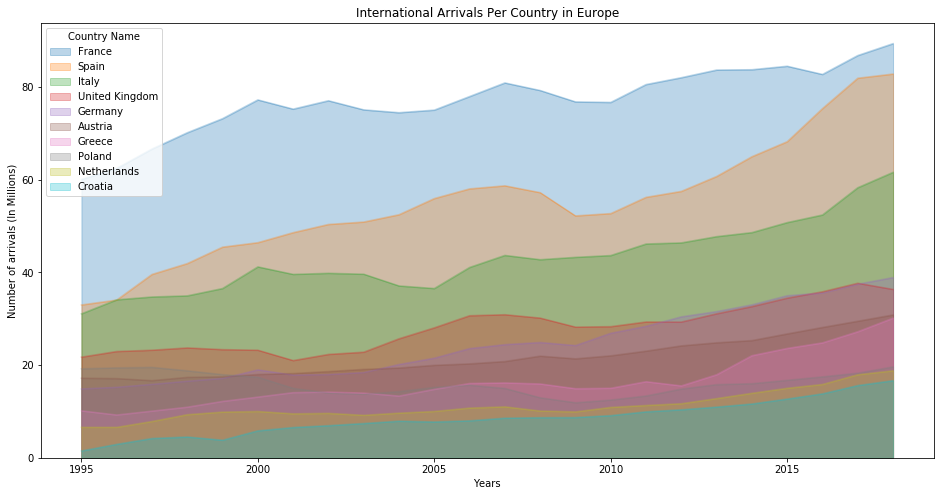

In [33]:
travel_df.index = travel_df.index.map(int)
travel_df.plot(kind='area', alpha=0.3, stacked=False, figsize=(16, 8))

plt.ylim(0)
plt.yscale('Linear')
#plt.ticklabel_format(style='plain')

plt.title('International Arrivals Per Country in Europe')
plt.ylabel('Number of arrivals (In Millions)')
plt.xlabel('Years')
plt.savefig('europe_international_arrivals.png', bbox_inches='tight')

From the above chart, we can see that the country with the largest international arrivals is France, followed by Spain and Italy. With this, we can surmise that choosing France, and by extension her capital, Paris, is a good choice as we would have a large target audience.

However, the chart is not very clear when it comes to whether there is an increasing trend of new international arrivals. To address this, we create 2 charts. The first would be a line chart to visualise the yearly international arrivals to France. The second would be a scatter plot and the regression analysis performed on the data provided. We now select the data specifically from France and apply simple regression modelling, to see if there is a positive trend.

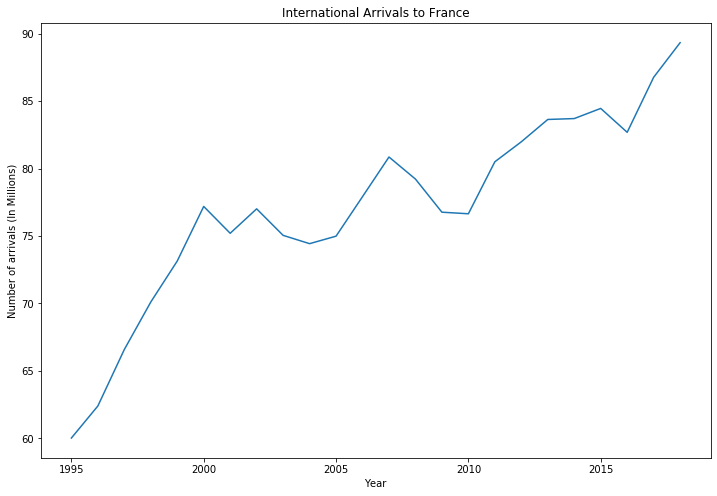

In [34]:
fr_arrivals = travel_df['France']
fr_arrivals.plot(kind='line', figsize=(12, 8))

plt.title('International Arrivals to France')
plt.ylabel('Number of arrivals (In Millions)')
plt.xlabel('Year')
plt.savefig('france_international_arrivals.png', bbox_inches='tight')

We can see that the range of international arrivals entering France from the year 2000 to 2010 is relatively stable at 75 to 80 million. From 2011 onwards, there is a significant increase in international arrivals to France. This further substantiates our choice of France as our destination.

While the above chart does show an increase in international arrivals in France, regression analysis can be applied to the dataset to see the trend. We now plot the France international arrival data in a scatter plot and perform regression analysis on the data.  

In [35]:
fr = pd.DataFrame(fr_arrivals)
fr = fr.reset_index()
fr = fr.rename(columns={'index':'Year'})
fr.head()

,Year,France
0,1995,60.033
1,1996,62.406
2,1997,66.591
3,1998,70.109
4,1999,73.147


In [36]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(fr[['Year']])
train_y = np.asanyarray(fr[['France']])
regr.fit (train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

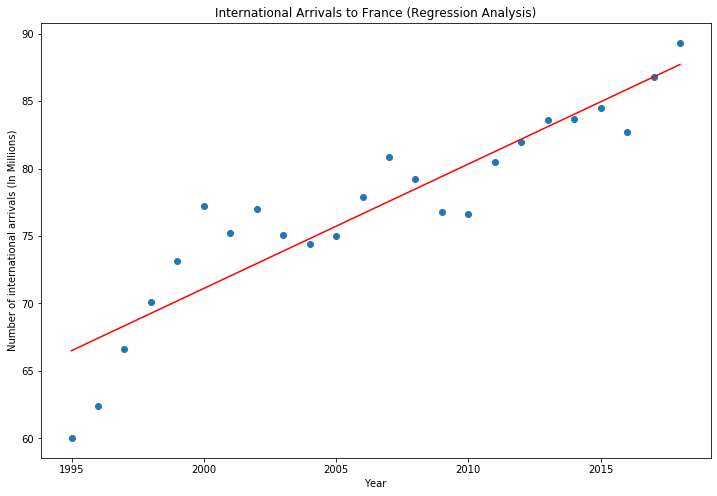

In [37]:
plt.figure(figsize=(12, 8))
plt.scatter(fr.Year, fr.France)
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.title('International Arrivals to France (Regression Analysis)')
plt.xlabel("Year")
plt.ylabel("Number of international arrivals (In Millions)")
plt.savefig('france_international_arrivals_regression.png', bbox_inches='tight')

### Exploratory analysis of Data

#### Populations in Singapore

We start by obtaining some insights of the population data obtained by using 'BeautifulSoup'. We observe the data specific for Singapore first. We sort the population and population density data and plot them to bar charts. The most populous and population dense neighborhoods are chosen for further analysis, using the venue data.

In [38]:
pop_df = []
pop_df = sg_df[['Neighborhood', 'Population']]
pop_df = pop_df.sort_values(by=['Population'], ascending = False)
pop_df = pop_df.set_index(['Neighborhood'])

# Choosing the top 10 largest neighborhoods for our dataset
pop_df = pop_df.head(10)

# Checking Data set created
pop_df.head()

,Population
Neighborhood,
Bedok,279380
Jurong West,264860
Tampines,256730
Woodlands,254730
Sengkang,244600


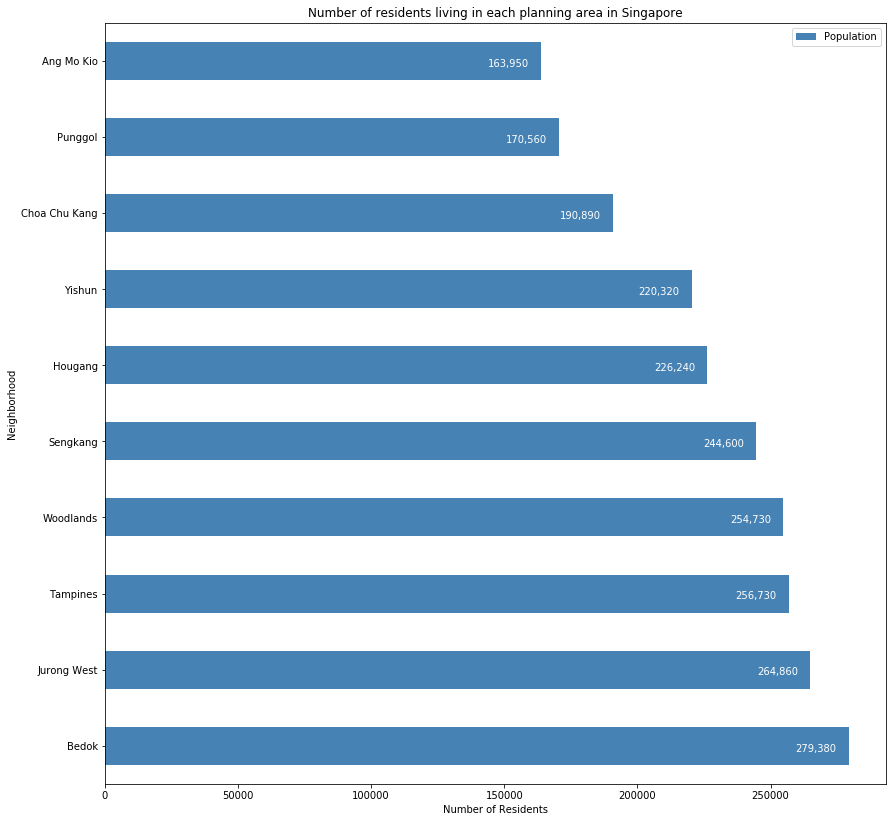

In [39]:
pop_df.plot(kind='barh', figsize=(14, 14), color='steelblue')
plt.xlabel('Number of Residents')
plt.title('Number of residents living in each planning area in Singapore')

for index, value in enumerate(pop_df['Population']):
    label = format(int(value), ",")
    plt.annotate(label, xy=(value-20000, index-0.07), color='white')
    
plt.savefig('sg_population.png', bbox_inches='tight')
plt.show()

In [40]:
den_df = []
den_df = sg_df[['Neighborhood', 'Area', 'Population']]
den_df['Density'] = den_df['Population']/den_df['Area']
den_sg = den_df.copy()
den_df = den_df.drop(['Area', 'Population'], axis=1)
den_df = den_df.sort_values(by=['Density'], ascending = False)
den_df = den_df.set_index(['Neighborhood'])

# Choosing the top 10 largest neighborhoods for our dataset
den_df = den_df.head(10)

# Checking Data set created
den_df.head()

,Density
Neighborhood,
Choa Chu Kang,31242.225859
Sengkang,23097.261568
Woodlands,18743.929360
Punggol,18261.241970
Jurong West,18029.952349


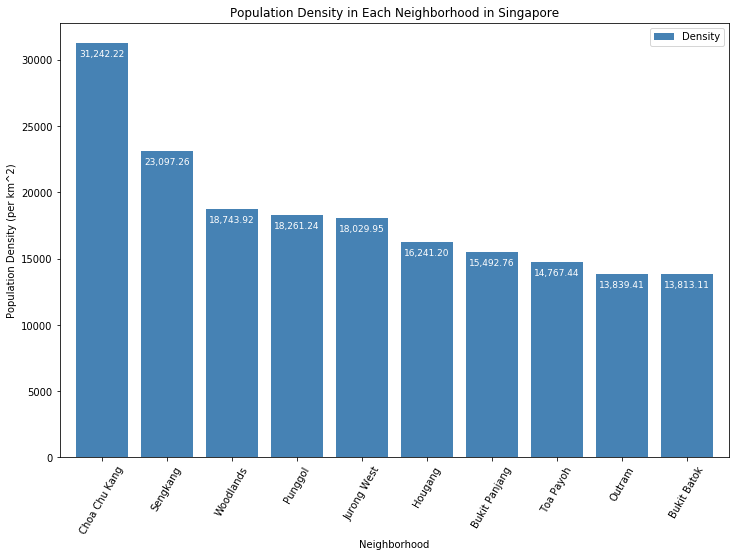

In [41]:
den_df.plot(kind='bar', color='steelblue', figsize=(12, 8), rot=60, width=0.8)
plt.ylabel('Population Density (per km^2)')
plt.title('Population Density in Each Neighborhood in Singapore')

for index, value in enumerate(den_df['Density']):
    label = format(float(value), ",")
    plt.annotate("{:.9s}".format(label), xy=(index-0.35, value-1000), color='white', fontsize=9)

plt.savefig('sg_pop-density.png', bbox_inches='tight')
plt.show()

The most populous and most population dense neighborhoods are chosen for further venue analysis.

In [42]:
top2_sg = den_sg.drop(['Area'], axis=1)
top2_sg = top2_sg.sort_values(by=['Population'], ascending = False).reset_index()
top2_lst = []
top2_lst.append(top2_sg['Neighborhood'][0])
top2_sg = top2_sg.sort_values(by=['Density'], ascending = False).reset_index()
top2_lst.append(top2_sg['Neighborhood'][0])
top2_lst

['Bedok', 'Choa Chu Kang']

### Exploratory analysis of Data

#### Populations in Paris

We now obtain some insights of the population data obtained by using 'BeautifulSoup'. We observe the data specific for Paris. Similar to the Singapore Data, we sort the population and population density data and plot them to bar charts. The most populous and population dense neighborhoods are chosen for further analysis, using the venue data.

In [43]:
paris_info = []
paris_info = paris_df[['Neighborhood', 'Area', 'Population']]
paris_info['Density'] = paris_info['Population']/paris_info['Area']
paris_info = paris_info.drop(['Area'], axis=1)

paris_info.head()

,Neighborhood,Population,Density
0,Saint-Germain-l'Auxerrois,1672,19.240506
1,Les Halles,8984,218.058252
2,Palais-Royal,3195,116.605839
3,Place-Vendôme,3044,113.159851
4,Gaillon,1345,71.542553


In [44]:
pop_paris_df = []
pop_paris_df = paris_info[['Neighborhood', 'Population']]
pop_paris_df = pop_paris_df.sort_values(by=['Population'], ascending = False)
pop_paris_df = pop_paris_df.set_index(['Neighborhood'])

# Choosing the top 10 largest neighborhoods for our dataset
pop_paris_df =pop_paris_df.head(10)

# Checking Data set created
pop_paris_df

,Population
Neighborhood,
Saint-Lambert,82032
La Gare,69008
Auteuil,67967
Grandes-Carrières,67152
Clignancourt,64868
Maison-Blanche,64797
Picpus,62947
Charonne,62901
Plaisance,57229


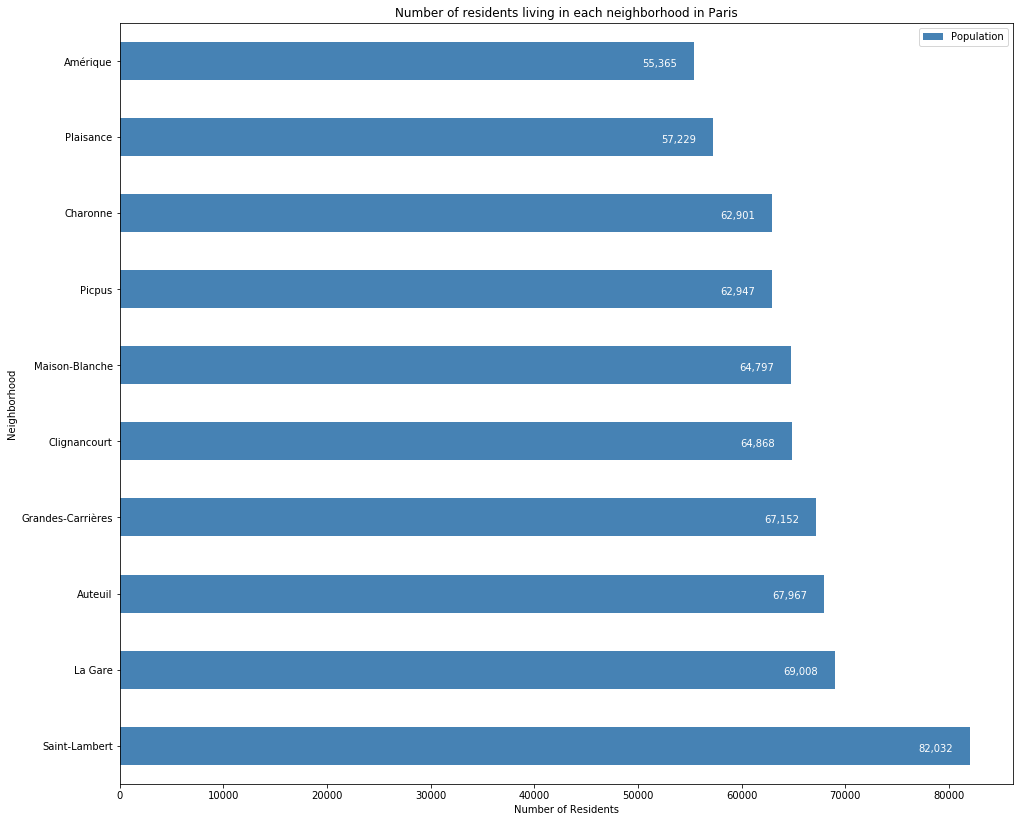

In [45]:
pop_paris_df.plot(kind='barh', figsize=(16, 14), color='steelblue')
plt.xlabel('Number of Residents')
plt.title('Number of residents living in each neighborhood in Paris')

for index, value in enumerate(pop_paris_df['Population']):
    label = format(int(value), ",")
    plt.annotate(label, xy=(value-5000, index-0.07), color='white')
    
plt.savefig('paris_population.png', bbox_inches='tight')
plt.show()

In [46]:
den_paris_df = []
den_paris_df = paris_info[['Neighborhood', 'Density']]
den_paris_df = den_paris_df.sort_values(by=['Density'], ascending = False)
den_paris_df = den_paris_df.set_index(['Neighborhood'])

# Choosing the top 10 largest neighborhoods for our dataset
den_paris_df = den_paris_df.head(10)

# Checking Data set created
den_paris_df

,Density
Neighborhood,
Folie-Méricourt,454.573003
Rochechouart,443.353293
Belleville,443.283767
La Villette,417.185070
La Roquette,405.460751
Clignancourt,392.425892
Sainte-Marguerite,392.215054
Saint-Ambroise,383.866348
Porte-Saint-Martin,379.720854


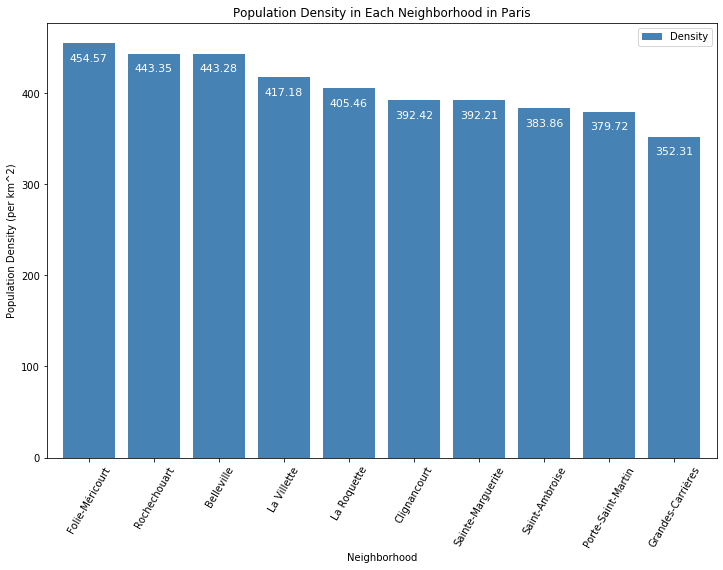

In [47]:
den_paris_df.plot(kind='bar', color='steelblue', figsize=(12, 8), rot=60, width=0.8)
plt.ylabel('Population Density (per km^2)')
plt.title('Population Density in Each Neighborhood in Paris')

for index, value in enumerate(den_paris_df['Density']):
    label = format(float(value), ",")
    plt.annotate("{:.6s}".format(label), xy=(index-0.3, value-20), color='white', fontsize=11)

plt.savefig('paris_pop-density_bar.png', bbox_inches='tight')
plt.show()

In [48]:
top2_pr = paris_info.copy()
top2_pr = top2_pr.sort_values(by=['Population'], ascending = False).reset_index()
top2_lst.append(top2_pr['Neighborhood'][0])
top2_pr = top2_pr.sort_values(by=['Density'], ascending = False).reset_index()
top2_lst.append(top2_pr['Neighborhood'][0])
top2_lst

['Bedok', 'Choa Chu Kang', 'Saint-Lambert', 'Folie-Méricourt']

### Exploratory analysis of Data

#### Venues in Singapore and Paris

We start by obtaining some insights of the venue data generated by the FourSquare API. Following this we start sorting and processing the data frame generated. One hot encoding is performed on the dataset.

In [49]:
uniqueValues = all_venues['Venue Category'].unique()
print('There are {} unique venue categories.'.format(len(all_venues['Venue Category'].unique())))

There are 352 unique venue categories.


In [50]:
all_onehot = []

# one hot encoding
all_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# A neighborhood column was noticed in the data frame. 
# This column of data is deemed not required and dropped from the data frame.
all_onehot = all_onehot.drop(columns='Neighborhood')

# We add the neighborhood column, from the all_venues dataframe, back to dataframe
all_onehot.insert(loc=0, column='Neighborhood', value=all_venues['Neighborhood'])

pd.options.display.max_columns = None
print(all_onehot.info())
all_onehot.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6968 entries, 0 to 6967
Columns: 352 entries, Neighborhood to Zoo Exhibit
dtypes: object(1), uint8(351)
memory usage: 2.4+ MB
None


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bay,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Casino,Caucasian Restaurant,Cemetery,Cha Chaan Teng,Champagne Bar,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Night Market,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Post Office,Provençal Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Romania

The data is now grouped into each neighborhood.

In [51]:
all_grouped = all_onehot.groupby('Neighborhood').mean().reset_index()
print(all_grouped.shape)
all_grouped.head()

(114, 352)


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bay,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Casino,Caucasian Restaurant,Cemetery,Cha Chaan Teng,Champagne Bar,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Night Market,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Post Office,Provençal Restaurant,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Romania

### Creating a visualisation to show the differences in the top 5 venues at the top most populous and population dense neighborhoods in Singapore and Paris.

In [52]:
top_grouped = all_grouped.set_index(['Neighborhood'])
top_grouped = top_grouped.transpose()
top_grouped.head()

Neighborhood,Amérique,Ang Mo Kio,Archives,Arsenal,Arts-et-Métiers,Auteuil,Batignolles,Bedok,Bel-Air,Belleville,Bercy,Bishan,Bonne-Nouvelle,Bukit Batok,Bukit Merah,Bukit Panjang,Chaillot,Champs-Élysées,Charonne,Chaussée-d'Antin,Choa Chu Kang,Clementi,Clignancourt,Combat,Croulebarbe,Downtown Core,Enfants-Rouges,Europe,Faubourg-Montmartre,Faubourg-du-Roule,Folie-Méricourt,Gaillon,Geylang,Goutte-d'Or,Grandes-Carrières,Grenelle,Gros-Caillou,Hougang,Hôpital-Saint-Louis,Jardin-des-Plantes,Javel,Jurong East,Jurong West,Kallang,La Chapelle,La Gare,La Madeleine,La Muette,La Roquette,La Villette,Les Halles,Les Invalides,Les Ternes,Mail,Maison-Blanche,Mandai,Marine Parade,Monnaie,Montparnasse,Necker,Newton,Notre-Dame,Notre-Dame-des-Champs,Novena,Odéon,Outram,Palais-Royal,Parc Montsouris,Pasir Ris,Petit-Montrouge,Picpus,Place-Vendôme,Plaine Monceau,Plaisance,Pont-de-Flandre,Porte-Dauphine,Porte-Saint-Denis,Porte-Saint-Martin,Punggol,Père-Lachaise,Quartier Saint-Victor,Queenstown,Quinze-Vingts,River Valley,Rochechouart,Rochor,Saint-Ambroise,Saint-Fargeau,Saint-Georges,Saint-Germain-des-Prés,Saint-Germain-l'Auxerrois,Saint-Gervais,Saint-Lambert,Saint-Merri,Saint-Thomas-d'Aquin,Saint-Vincent-de-Paul,Sainte-Avoye,Sainte-Marguerite,Salpêtrière,Sembawang,Sengkang,Serangoon,Singapore River,Sorbonne,Tampines,Tanglin,Toa Payoh,Upper Bukit Timah,Val-de-Grâce,Vivienne,Woodlands,Yishun,École-Militaire,Épinettes
Accessories Store,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.013514,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
Afghan Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015152,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
African Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.04,0.02439,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.000000,0.019608,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.03,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.034483,0.0,0.0,0.015152,0.011765,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.000000,0.0,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.014706,0.0,0.00,0.0,0.0,0.019608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.01,0.0,0.00,0.000000,0.047619,0.0,0.0,0.0,0.0,0.0,0.00000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
Alsatian Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00,0.0,0.01,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
American Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.00,0.00000,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.00,0.0,0.0,0.015385,0.000000,0.0,0.02,0.0,0.0,0.0,0.01,0.0,0.00,0.00,0

Sorting the data according to the most common venues and relating each neighborhood to the most populous neighborhood of Bedok. The top most populous and most population dense neighborhood, the top 5 most common venues are selected in relation to 'Bedok'.

In [53]:
commVen = top_grouped.sort_values(by=['Bedok'], ascending = False).head(5)
commVen = commVen[top2_lst]
commVen

Neighborhood,Bedok,Choa Chu Kang,Saint-Lambert,Folie-Méricourt
Coffee Shop,0.096774,0.090909,0.014085,0.01
Sushi Restaurant,0.048387,0.045455,0.028169,0.00
Sandwich Place,0.048387,0.045455,0.014085,0.01
Chinese Restaurant,0.048387,0.000000,0.000000,0.01
Asian Restaurant,0.048387,0.090909,0.014085,0.02


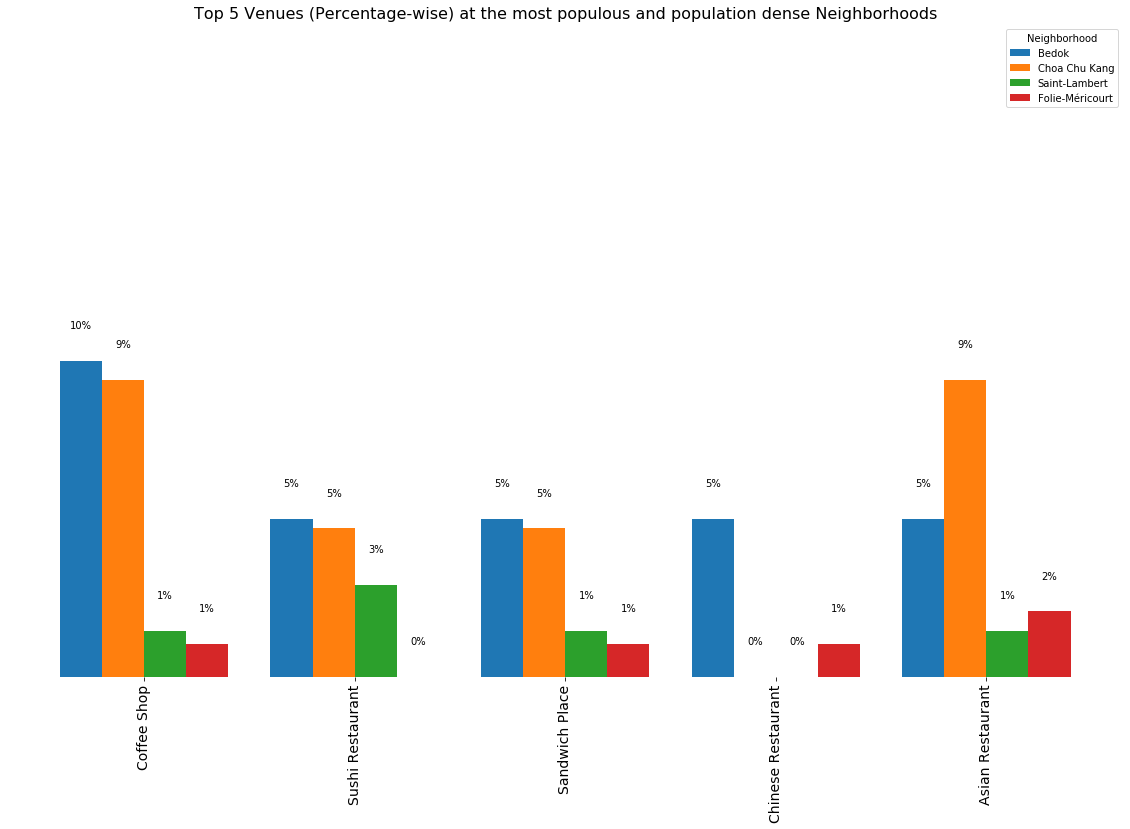

In [54]:
ax = commVen.plot(kind='bar', figsize=(20, 12), width = 0.8, ylim=(0,1), fontsize= 14)

ax.set_title("Top 5 Venues (Percentage-wise) at the most populous and population dense Neighborhoods", fontsize = 16)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylim(0, 0.2)
plt.yticks([])
    
for value in ax.patches:
    width, height = value.get_width(), value.get_height()
    x, y = value.get_xy() 
    ax.annotate('{:.0%}'.format(height), (value.get_x()+.5*width, value.get_y() + height + 0.01),
                ha = 'center')
    
plt.savefig('top5_venues_neighborhoods.png', bbox_inches='tight')

To provide additional comparison, we now compare the venues when the dataframe is sorted by the most populous neighborhood in Paris, Saint-Lambert.

In [55]:
commVen = top_grouped.sort_values(by=['Saint-Lambert'], ascending = False).head(5)
commVen = commVen[top2_lst]
commVen

Neighborhood,Bedok,Choa Chu Kang,Saint-Lambert,Folie-Méricourt
French Restaurant,0.016129,0.000000,0.183099,0.12
Hotel,0.000000,0.000000,0.098592,0.02
Bakery,0.032258,0.090909,0.056338,0.05
Sports Bar,0.016129,0.000000,0.042254,0.00
Café,0.032258,0.045455,0.042254,0.01


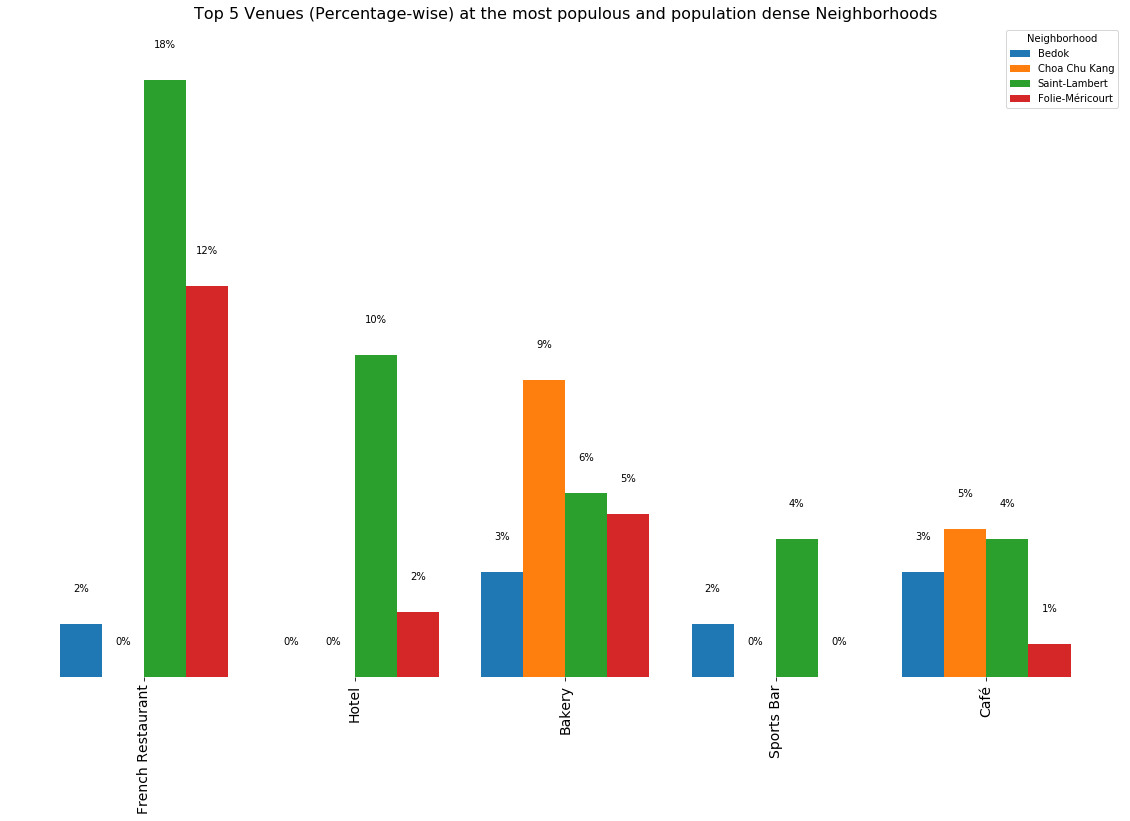

In [56]:
ax = commVen.plot(kind='bar', figsize=(20, 12), width = 0.8, ylim=(0,1), fontsize= 14)

ax.set_title("Top 5 Venues (Percentage-wise) at the most populous and population dense Neighborhoods", fontsize = 16)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylim(0, 0.2)
plt.yticks([])
    
for value in ax.patches:
    width, height = value.get_width(), value.get_height()
    x, y = value.get_xy() 
    ax.annotate('{:.0%}'.format(height), (value.get_x()+.5*width, value.get_y() + height + 0.01),
                ha = 'center')
    
plt.savefig('fr_top5_venues_neighborhoods.png', bbox_inches='tight')

# Analysis of Data

## Clustering Venues in Singapore and Paris

We start by obtaining the top venue data generated by the FourSquare API. Following this we start sorting and processing the data frame generated. One hot encoding was performed on the dataset.

We first define a function to assist in the creation of a data frame that shows the top 10 venues in each neighborhood.

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We create the dataframe showing the top 10 venues for each neighborhood.

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = all_grouped['Neighborhood']

for ind in np.arange(all_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,Bus Stop,French Restaurant,Theater,Health Food Store,Supermarket,Café,Arts & Entertainment,Arts & Crafts Store,Smoke Shop,Bistro
1,Ang Mo Kio,Food Court,Coffee Shop,Dessert Shop,Supermarket,Snack Place,Japanese Restaurant,Bubble Tea Shop,Department Store,Gym / Fitness Center,Multiplex
2,Archives,French Restaurant,Clothing Store,Burger Joint,Bar,Bistro,Bookstore,Italian Restaurant,Coffee Shop,Hotel,Japanese Restaurant
3,Arsenal,French Restaurant,Hotel,Plaza,Tapas Restaurant,Park,Gastropub,Boat or Ferry,Cocktail Bar,Thai Restaurant,Italian Restaurant
4,Arts-et-Métiers,French Restaurant,Hotel,Cocktail Bar,Bar,Chinese Restaurant,Art Gallery,Café,Italian Restaurant,Bakery,Restaurant


### Elbow Method for KMeans

The elbow method is used to find the optimal KMeans cluster number. The optimal cluster number is then used to cluster the data obtained from the FourSquare API and previously pre-processed.

In [59]:
kt_merge = all_grouped.copy()
kt_merge = kt_merge.set_index(['Neighborhood']).fillna(0)

sum_sqdist = []
K = range(1,20)
opt_k = 0
i = 0
opk = []
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(kt_merge)
    sum_sqdist.append(km.inertia_)


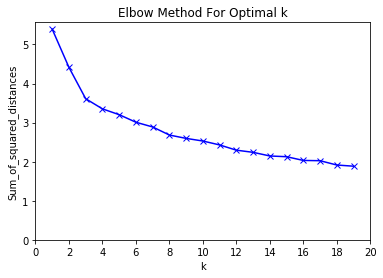

In [60]:
plt.plot(K, sum_sqdist, 'bx-')
plt.xticks(np.arange(0, 21, 2.0))
plt.yticks(np.arange(0, 6, 1.0))
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow_method_optimal_k.png', bbox_inches='tight')
plt.show()

From the graph above, we can see that the elbow point is at 8 clusters. Subsequent increases in clusters would not reduce the sum of squared distances significantly. Therefore, 8 clusters are chosen.

In [61]:
# set number of clusters
kclusters = 8
lst_neighborhood = all_grouped['Neighborhood']

total_grouped_clustering = all_grouped.drop('Neighborhood', 1)
total_grouped_clustering = total_grouped_clustering.fillna(0)

# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=1111).fit(total_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:]

array([5, 2, 5, 5, 5, 1, 1, 2, 1, 1, 1, 2, 5, 2, 6, 2, 0, 0, 1, 5, 2, 2,
       1, 1, 1, 5, 5, 0, 1, 0, 1, 5, 4, 2, 1, 0, 0, 2, 1, 5, 1, 2, 2, 7,
       5, 5, 5, 5, 1, 5, 1, 0, 0, 5, 4, 3, 5, 5, 5, 0, 4, 5, 5, 2, 5, 4,
       5, 5, 2, 0, 5, 5, 0, 0, 5, 5, 1, 1, 2, 1, 1, 4, 1, 5, 0, 4, 1, 5,
       1, 5, 5, 5, 0, 5, 0, 0, 5, 1, 1, 2, 2, 2, 5, 5, 2, 5, 4, 4, 1, 5,
       2, 4, 0, 1])

In [62]:
# add clustering labels
try:
    neighborhoods_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
    
except:
    neighborhoods_venues_sorted = neighborhoods_venues_sorted

all_cluster_merged = []
all_cluster_merged = all_neighborhoods.copy()

# merge sg_grouped with sg_full to add latitude/longitude for each neighborhood
all_cluster_merged = all_cluster_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
all_cluster_merged = all_cluster_merged.fillna(0)
all_cluster_merged['Cluster Labels'] = all_cluster_merged['Cluster Labels'].astype(int)

all_cluster_merged.head()

,Neighborhood,Region,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ang Mo Kio,North-East Region,13.94,163950,1.370080,103.849523,2,Food Court,Coffee Shop,Dessert Shop,Supermarket,Snack Place,Japanese Restaurant,Bubble Tea Shop,Department Store,Gym / Fitness Center,Multiplex
1,Bedok,East Region,21.69,279380,1.323976,103.930216,2,Coffee Shop,Asian Restaurant,Food Court,Sandwich Place,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Thrift / Vintage Store,Bakery,Supermarket
2,Bishan,Central Region,7.62,88010,1.350986,103.848255,2,Food Court,Coffee Shop,Bubble Tea Shop,Ice Cream Shop,Cosmetics Shop,Supermarket,Chinese Restaurant,Japanese Restaurant,Café,Asian Restaurant
3,Bukit Batok,West Region,11.13,153740,1.349057,103.749591,2,Coffee Shop,Food Court,Chinese Restaurant,Mobile Phone Shop,Multiplex,Fast Food Restaurant,Park,Bowling Alley,Café,Malay Restaurant
4,Bukit Merah,Central Region,14.34,151980,1.270439,103.828318,6,Intersection,Wine Shop,Bus Station,Hotel,Fish & Chips Shop,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant


In [63]:
all_cluster_merged.loc[all_cluster_merged['Cluster Labels'] == 0, all_cluster_merged.columns[[0] + list(range(1, all_cluster_merged.shape[1]))]]

,Neighborhood,Region,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Saint-Thomas-d'Aquin,7th Arrondissement,82.7,12661,48.854926,2.325311,0,French Restaurant,Hotel,Italian Restaurant,Art Gallery,Bakery,Bookstore,Café,American Restaurant,Furniture / Home Store,Garden
25,Les Invalides,7th Arrondissement,107.4,6276,48.857037,2.311878,0,French Restaurant,Hotel,Italian Restaurant,Plaza,Café,Cocktail Bar,Coffee Shop,History Museum,Bakery,Garden
26,École-Militaire,7th Arrondissement,80.8,12895,48.851848,2.304756,0,French Restaurant,Hotel,Coffee Shop,Plaza,Miscellaneous Shop,Bistro,Gym / Fitness Center,Historic Site,Korean Restaurant,Supermarket
27,Gros-Caillou,7th Arrondissement,138.2,25156,48.857394,2.300540,0,French Restaurant,Italian Restaurant,Hotel,Coffee Shop,Ice Cream Shop,Café,Pizza Place,Bistro,Dessert Shop,Burger Joint
28,Champs-Élysées,8th Arrondissement,114.1,4614,48.870757,2.305331,0,Hotel,French Restaurant,Cosmetics Shop,Clothing Store,Tailor Shop,Italian Restaurant,Art Gallery,Boutique,Steakhouse,Japanese Restaurant
29,Faubourg-du-Roule,8th Arrondissement,79.6,10038,48.874026,2.302803,0,Hotel,French Restaurant,Jewelry Store,Cosmetics Shop,Bakery,Italian Restaurant,Tailor Shop,Department Store,Asian Restaurant,Men's Store
31,Europe,8th Arrondissement,118.3,18606,48.878768,2.322264,0,Hotel,French Restaurant,Restaurant,Bistro,Thai Restaurant,Asian Restaurant,Cosmetics Shop,Coffee Shop,Sandwich Place,Café
35,Rochechouart,9th Arrondissement,50.1,22212,48.880128,2.345008,0,French Restaurant,Hotel,Bakery,Vegetarian / Vegan Restaurant,Coffee Shop,Bar,Pizza Place,Restaurant,Italian Restaurant,Convenience Store
36,Saint-Vincent-de-Paul,10th Arrondissement,92.7,21624,48.880065,2.356772,0,French Restaurant,Indian Restaurant,Japanese Restaurant,Hotel,African Restaurant,Wine Shop,Italian Restaurant,Record Shop,Coffee Shop,Seafood Restaurant
54,Petit-Montrouge,14th Arrondissement,134.6,37230,48.826938,2.326241,0,French Restaurant,Hotel,Supermarket,Italian Restaurant,Bistro,Bakery,Plaza,Sushi Restaurant,Discount Store,Café


In [64]:
all_cluster_merged.loc[all_cluster_merged['Cluster Labels'] == 1, all_cluster_merged.columns[[0] + list(range(1, all_cluster_merged.shape[1]))]]

,Neighborhood,Region,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Les Halles,1st Arrondissement,41.2,8984,48.862466,2.346009,1,French Restaurant,Bakery,Italian Restaurant,Hotel,Wine Bar,Clothing Store,Restaurant,Chinese Restaurant,Cocktail Bar,Pizza Place
16,Quartier Saint-Victor,5th Arrondissement,60.4,11661,48.847926,2.355269,1,French Restaurant,Italian Restaurant,Hotel,Café,Bakery,Zoo Exhibit,Bar,Park,Museum,Bistro
18,Val-de-Grâce,5th Arrondissement,70.4,19492,48.842213,2.343882,1,French Restaurant,Hotel,Bar,Creperie,Bakery,Italian Restaurant,Plaza,Asian Restaurant,Wine Bar,Science Museum
32,Saint-Georges,9th Arrondissement,71.7,20850,48.878447,2.337458,1,French Restaurant,Hotel,Bar,Bistro,Japanese Restaurant,Wine Bar,Gym / Fitness Center,Theater,Burger Joint,Vegetarian / Vegan Restaurant
34,Faubourg-Montmartre,9th Arrondissement,41.7,9233,48.873703,2.342912,1,French Restaurant,Hotel,Pizza Place,Coffee Shop,Bar,Italian Restaurant,Cocktail Bar,Bistro,Japanese Restaurant,Bakery
37,Porte-Saint-Denis,10th Arrondissement,47.2,15066,48.869793,2.352686,1,French Restaurant,Bar,Hotel,Cocktail Bar,Coffee Shop,Restaurant,Indie Movie Theater,Farmers Market,Gym / Fitness Center,Bakery
38,Porte-Saint-Martin,10th Arrondissement,60.9,23125,48.869146,2.355651,1,French Restaurant,Bar,Hotel,Cocktail Bar,Coffee Shop,Bakery,Italian Restaurant,Restaurant,Chinese Restaurant,Vietnamese Restaurant
39,Hôpital-Saint-Louis,10th Arrondissement,88.4,29870,48.876619,2.366364,1,French Restaurant,Bar,Café,Coffee Shop,Bistro,Sandwich Place,Wine Bar,Thai Restaurant,Pizza Place,Italian Restaurant
40,Folie-Méricourt,11th Arrondissement,72.6,33002,48.867380,2.373423,1,Bar,French Restaurant,Restaurant,Bakery,Wine Bar,Pizza Place,African Restaurant,Burger Joint,Bookstore,Juice Bar
41,Saint-Ambroise,11th Arrondissement,83.8,32168,48.861052,2.374796,1,French Restaurant,Restaurant,Bar,Coffee Shop,Bakery,Hotel,Italian Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Mexican Restaurant


In [65]:
all_cluster_merged.loc[all_cluster_merged['Cluster Labels'] == 2, all_cluster_merged.columns[[0] + list(range(1, all_cluster_merged.shape[1]))]]

,Neighborhood,Region,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ang Mo Kio,North-East Region,13.94,163950,1.370080,103.849523,2,Food Court,Coffee Shop,Dessert Shop,Supermarket,Snack Place,Japanese Restaurant,Bubble Tea Shop,Department Store,Gym / Fitness Center,Multiplex
1,Bedok,East Region,21.69,279380,1.323976,103.930216,2,Coffee Shop,Asian Restaurant,Food Court,Sandwich Place,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Thrift / Vintage Store,Bakery,Supermarket
2,Bishan,Central Region,7.62,88010,1.350986,103.848255,2,Food Court,Coffee Shop,Bubble Tea Shop,Ice Cream Shop,Cosmetics Shop,Supermarket,Chinese Restaurant,Japanese Restaurant,Café,Asian Restaurant
3,Bukit Batok,West Region,11.13,153740,1.349057,103.749591,2,Coffee Shop,Food Court,Chinese Restaurant,Mobile Phone Shop,Multiplex,Fast Food Restaurant,Park,Bowling Alley,Café,Malay Restaurant
5,Bukit Panjang,West Region,8.99,139280,1.379149,103.761413,2,Sushi Restaurant,Fast Food Restaurant,Coffee Shop,Café,Shopping Mall,Asian Restaurant,Light Rail Station,Bookstore,Bistro,Chinese Breakfast Place
7,Choa Chu Kang,West Region,6.11,190890,1.384749,103.744534,2,Asian Restaurant,Coffee Shop,Shoe Store,Bakery,Fast Food Restaurant,Thai Restaurant,Noodle House,Bookstore,Sushi Restaurant,Supermarket
8,Clementi,West Region,9.49,92420,1.315100,103.765231,2,Coffee Shop,Food Court,Dessert Shop,Electronics Store,Chinese Restaurant,Asian Restaurant,Gym,Chinese Breakfast Place,Bakery,Dim Sum Restaurant
11,Hougang,North-East Region,13.93,226240,1.370801,103.892544,2,Food Court,Coffee Shop,Fast Food Restaurant,Chinese Restaurant,Shopping Mall,Supermarket,Café,Metro Station,Frozen Yogurt Shop,Kitchen Supply Store
12,Jurong East,West Region,17.83,79240,1.333108,103.742294,2,Japanese Restaurant,Café,Chinese Restaurant,Food Court,Coffee Shop,Shopping Mall,Department Store,Sushi Restaurant,Bubble Tea Shop,Korean Restaurant
13,Jurong West,West Region,14.69,264860,1.339636,103.707339,2,Japanese Restaurant,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Coffee Shop,Dessert Shop,Indian Restaurant,Electronics Store,Cha Chaan Teng


In [66]:
all_cluster_merged.loc[all_cluster_merged['Cluster Labels'] == 3, all_cluster_merged.columns[[0] + list(range(1, all_cluster_merged.shape[1]))]]

,Neighborhood,Region,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Mandai,North Region,11.77,2090,1.423535,103.80335,3,Asian Restaurant,Zoo Exhibit,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant


In [67]:
all_cluster_merged.loc[all_cluster_merged['Cluster Labels'] == 4, all_cluster_merged.columns[[0] + list(range(1, all_cluster_merged.shape[1]))]]

,Neighborhood,Region,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Upper Bukit Timah,Central Region,17.53,77430,1.329448,103.794166,4,Indian Restaurant,Food Court,Coffee Shop,Bus Station,Bakery,Restaurant,Churrascaria,Seafood Restaurant,Café,Pizza Place
10,Geylang,Central Region,9.64,110200,1.318186,103.887056,4,Chinese Restaurant,Noodle House,Vegetarian / Vegan Restaurant,Food Court,Dim Sum Restaurant,Asian Restaurant,Grocery Store,Basketball Court,Wings Joint,Cantonese Restaurant
17,Newton,Central Region,2.07,8030,1.313183,103.838040,4,Chinese Restaurant,Seafood Restaurant,Italian Restaurant,Hotel Bar,Dance Studio,Movie Theater,Café,Noodle House,Grocery Store,Gym / Fitness Center
19,Outram,Central Region,1.37,18960,1.282870,103.837860,4,Seafood Restaurant,Farmers Market,Grocery Store,Nail Salon,Bakery,Gastropub,Hotel,Coffee Shop,Chinese Restaurant,Dim Sum Restaurant
22,Queenstown,Central Region,20.43,96340,1.294623,103.806037,4,Food Court,Noodle House,Chinese Restaurant,Stadium,Café,BBQ Joint,Supermarket,Seafood Restaurant,Vegetarian / Vegan Restaurant,Train Station
24,Rochor,Central Region,1.62,13340,1.303918,103.852789,4,Indian Restaurant,Café,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,General College & University,Chinese Restaurant,Dive Bar,Sushi Restaurant,Shopping Plaza,Gaming Cafe
31,Toa Payoh,Central Region,8.17,120650,1.335391,103.849741,4,Noodle House,Chinese Restaurant,Food Court,Coffee Shop,Steakhouse,Asian Restaurant,Dessert Shop,Thai Restaurant,Café,Snack Place
33,Yishun,North Region,21.24,220320,1.429384,103.835028,4,Chinese Restaurant,Food Court,Coffee Shop,Italian Restaurant,Hainan Restaurant,Park,Fried Chicken Joint,Supermarket,Indian Restaurant,Tea Room
50,Maison-Blanche,13th Arrondissement,223.20,64797,48.822474,2.358504,4,Vietnamese Restaurant,Asian Restaurant,Chinese Restaurant,Thai Restaurant,Cantonese Restaurant,Cambodian Restaurant,Juice Bar,French Restaurant,Park,Butcher


In [68]:
all_cluster_merged.loc[all_cluster_merged['Cluster Labels'] == 5, all_cluster_merged.columns[[0] + list(range(1, all_cluster_merged.shape[1]))]]

,Neighborhood,Region,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Downtown Core,Central Region,4.34,2720,1.287475,103.856033,5,Theater,Boutique,Café,Concert Hall,Performing Arts Venue,Bistro,Dim Sum Restaurant,Steakhouse,Event Space,Coffee Shop
16,Marine Parade,Central Region,6.12,46390,1.302689,103.907395,5,Hotel,Multiplex,Japanese Restaurant,Massage Studio,Chinese Restaurant,Indian Restaurant,Salad Place,Recreation Center,Steakhouse,Supermarket
23,River Valley,Central Region,1.48,10250,1.297582,103.836514,5,Clothing Store,Hotel,Ramen Restaurant,Shopping Mall,Shoe Store,Restaurant,Café,Grocery Store,Beer Garden,Discount Store
28,Singapore River,Central Region,0.96,3070,1.289178,103.845154,5,Japanese Restaurant,Hotel,Nightclub,Café,Italian Restaurant,Bar,Thai Restaurant,Seafood Restaurant,Food Court,Mexican Restaurant
30,Tanglin,Central Region,7.63,21630,1.306044,103.815280,5,Park,Thai Restaurant,Bus Station,French Restaurant,Garden,Lake,Trail,Modern European Restaurant,Museum,Café
0,Saint-Germain-l'Auxerrois,1st Arrondissement,86.90,1672,48.860211,2.336299,5,Hotel,French Restaurant,Plaza,Historic Site,Coffee Shop,Café,Art Museum,Cosmetics Shop,Clothing Store,Exhibit
2,Palais-Royal,1st Arrondissement,27.40,3195,48.863585,2.336204,5,Japanese Restaurant,French Restaurant,Plaza,Hotel,Café,Coffee Shop,Wine Bar,Italian Restaurant,Historic Site,Art Museum
3,Place-Vendôme,1st Arrondissement,26.90,3044,48.867463,2.329428,5,Hotel,Japanese Restaurant,French Restaurant,Dessert Shop,Plaza,Boutique,Bakery,Pastry Shop,Gourmet Shop,Chocolate Shop
4,Gaillon,2nd Arrondissement,18.80,1345,48.869135,2.332909,5,Hotel,Japanese Restaurant,French Restaurant,Chocolate Shop,Wine Bar,Jewelry Store,Bakery,Coffee Shop,Bookstore,Taiwanese Restaurant
5,Vivienne,2nd Arrondissement,24.40,2917,48.868859,2.339363,5,Japanese Restaurant,French Restaurant,Wine Bar,Bistro,Hotel,Coffee Shop,Clothing Store,Salad Place,Bookstore,Italian Restaurant


In [69]:
all_cluster_merged.loc[all_cluster_merged['Cluster Labels'] == 6, all_cluster_merged.columns[[0] + list(range(1, all_cluster_merged.shape[1]))]]

,Neighborhood,Region,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bukit Merah,Central Region,14.34,151980,1.270439,103.828318,6,Intersection,Wine Shop,Bus Station,Hotel,Fish & Chips Shop,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant


In [70]:
all_cluster_merged.loc[all_cluster_merged['Cluster Labels'] == 7, all_cluster_merged.columns[[0] + list(range(1, all_cluster_merged.shape[1]))]]

,Neighborhood,Region,Area,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Kallang,Central Region,9.17,101520,1.310759,103.866262,7,Hostel,Asian Restaurant,Supermarket,Restaurant,Coffee Shop,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit


Saving the data to a CSV file

In [73]:
all_cluster_merged.to_csv('all_cluster_merged.csv', index=True)

## Visualization of the clusters in Paris

A map of Paris is now visualized with the respective clustered neighborhoods. We start by getting the coordinate information for the city of Paris.

In [71]:
address = 'Paris, FR'

geolocator = Nominatim(user_agent="fr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [74]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_cluster_merged['Latitude'], all_cluster_merged['Longitude'], all_cluster_merged['Neighborhood'], all_cluster_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results and Discussion

With the neighborhoods clustered using K Means clustering method, we can see that there are 5 major clusters out of the 8 clusters selection to run K Means. These clusters are largely representative of the cities that they are in, with Cluster 0, Cluster 1 and Cluster 5 containing mostly neighborhoods from Paris and the remaining clusters containing mostly neighborhoods from Singapore.

For a first-time traveler to Paris, the neighborhoods in Cluster 5 would be an attractive location to stay in, as they are like 5 neighborhoods in Singapore. This indicates that the Singapore neighborhoods in Clusters 5 share similar characteristics to their French counterparts and would not cause too much of a culture shock to new visitors. This is seen by the majority Parisian neighborhoods in Cluster 5, but still similar enough to Singapore to contain 5 local Neighborhoods. 

Travelers that have been to Paris, from Singapore, may choose the neighborhoods in Cluster 0 for their stay. The neighborhoods in Cluster 0 contain many hotels and French restaurants. Many of the neighborhoods in Cluster 0 are very indicative of French culture, with the most popular venue being French Restaurants. The second most common venue is the hotel. This allows for the traveler to easily find accommodation, immerse themselves into French culture and provide a sufficiently different travel experience.

Long term travelers and migrants may consider choosing the neighborhoods in Clusters 2 & 4, to rent a medium/long term rental or apartment. The French Neighborhoods Goutte-d'Or and Maison-Blanche are most like popular residential neighborhoods in Singapore. Additionally, we can see that Cluster 2 contains the most populous and the most population dense neighborhoods in Singapore.

Interestingly, we note that there are 3 single neighborhood clusters after the completion of the analysis. The neighborhoods in these clusters are all Singaporean neighborhoods. Looking into the venue data, the 3 neighborhoods contain unique top common venues. These might be due to the neighborhood coordinates obtained using the geocoder library. As the activity center of neighborhoods may not correspond to the geographical center of the neighborhood, these unique venues, like ‘Intersection’, are more likely.

# Conclusion

This project was created to identify similar neighborhoods between Singapore and Paris. The project aims to address the concern travelers or migrants from Singapore to France have when picking a place to stay. The project starts out with visualizing data from the World Bank to determine if there is an increasing trend in travel from Singapore to France. We can see that the overall trend for travel to European nations are on an increase. With France having the largest international arrivals compared to other high-income countries in Europe.

The venue information collected from the FourSquare API is used to cluster the neighborhoods. The clustering is performed using the K Means method. This clustering of the neighborhoods helped determine the similarity of the neighborhood and help decide for a traveler or migrant reaching Paris from Singapore.

From Cluster 1, the Parisian neighborhoods are quite like each other and tend to be significantly different from Singaporean neighborhoods. Nonetheless, it can be seen from the results that Parisian neighborhoods like Maison-Blanche and Goutte-d'Or, are good for long term migrants. 

Further decision on an optimal location is determined by the stake holders on the characteristics of the neighborhoods and any additional requirements. Additional factors that would affect the decision would be rental cost, proximity of culture specific cuisine, or proximity to amenities like parks or cinemas. Further Analysis would require additional criteria and would benefit from including rental information into the analysis.